# ***Mercari Price Suggestion Challenge***

## **1 Import Libraries**





In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
!pip install stop-words

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import gc
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import math
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from prettytable import PrettyTable
import pickle
import zipfile
from tqdm import tqdm
import os
from sklearn.linear_model import Ridge

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from stop_words import get_stop_words
from collections import Counter

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense,Flatten
from tensorflow.keras.models import Model
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
tf.keras.backend.clear_session()

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **1.1 import data**



In [ ]:
PATH = 'My Drive/kì 2/học máy/mercari-price-suggestion-challenge/'

In [ ]:
train = pd.read_csv('/content/gdrive/'+ PATH +'data/train.tsv',sep='\t')

In [ ]:
test = pd.read_csv('/content/gdrive/'+ PATH + 'data/test_stg2.tsv',sep='\t')

In [ ]:
train.shape

(1482535, 8)

In [ ]:
test.shape

(3460725, 7)

In [ ]:
print(train.columns)

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')


In [ ]:
print(test.columns)

Index(['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description'],
      dtype='object')


In [ ]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [ ]:
print(train.isnull().sum())

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64


## **2 Exploratory Data Analysis**

### **2.1 Univariate analysis of category_name**

In [ ]:
category_count = train['category_name'].value_counts()
category_count

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Vintage & Collectibles/Furniture/Shelf                1
Handmade/Patterns/Painting                            1
Handmade/Glass/Vases                                  1
Handmade/Quilts/Trim                                  1
Handmade/Bags and Purses/Other                        1
Name: category_name, Length: 1287, dtype: int64

In [ ]:
category_count_te = test['category_name'].value_counts()
category_count_te

Women/Athletic Apparel/Pants, Tights, Leggings    139412
Women/Tops & Blouses/T-Shirts                     108334
Beauty/Makeup/Face                                 80054
Beauty/Makeup/Lips                                 69655
Electronics/Video Games & Consoles/Games           62577
                                                   ...  
Other/Pet Supplies/Pet Food                            1
Handmade/Accessories/Belt                              1
Handmade/Toys/Doll                                     1
Handmade/Children/Housewares                           1
Home/Home Décor/Draft Stoppers                         1
Name: category_name, Length: 1335, dtype: int64

Có tổng cộng 1287 categories trong tập dữ liệu train và có 1335 categories trong tập dữ liệu test. Mỗi categories thì được chia ra 3 loại category con

**Splitting categories into subcategories:**

In [ ]:
# tách caterory ra làm 3 category con
def split_categories(category):
  try:
    sub_cat_1,sub_cat_2,sub_cat_3 = category.split("/")
    return sub_cat_1,sub_cat_2,sub_cat_3
  except:
    return ("No label","No label","No label")

In [ ]:
# sử dụng hàm split_categories để tách category ra làm 3 category con và tạo thành 3 cột mới : 'main_category', 'sub_cat_1','sub_cat_2'
def create_split_categories(data):
  data['main_category'],data['sub_cat_1'],data['sub_cat_2']=zip(*data['category_name'].\
                                                                apply(lambda x: split_categories(x)))

In [ ]:
create_split_categories(train)
create_split_categories(test)

In [ ]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_cat_1,sub_cat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [ ]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,main_category,sub_cat_1,sub_cat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


In [ ]:
main_category_count = train['main_category'].value_counts()
sub_1_count = train['sub_cat_1'].value_counts()
sub_2_count = train['sub_cat_2'].value_counts()

main_category_count

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               119631
Men                        93363
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30840
Sports & Outdoors          24331
No label                   10716
Name: main_category, dtype: int64

In [ ]:
sub_1_count

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: sub_cat_1, Length: 114, dtype: int64

In [ ]:
sub_2_count

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Videogame                      1
Bathroom                       1
Towel                          1
Storage Solutions              1
Zipper                         1
Name: sub_cat_2, Length: 865, dtype: int64

**Observation:**
Có 11 loại mặt hàng chính , chúng được chia ra làm 114 loại mặt hàng levle 1 và 865 loại mặt hàng level 2

In [ ]:
main_category_count_te = test['main_category'].value_counts()
sub_1_count_te = test['sub_cat_1'].value_counts()
sub_2_count_te = test['sub_cat_2'].value_counts()

main_category_count_te

Women                     1549092
Beauty                     485171
Kids                       400135
Electronics                280006
Men                        218240
Home                       159171
Vintage & Collectibles     108512
Other                      106712
Handmade                    71620
Sports & Outdoors           57050
No label                    25016
Name: main_category, dtype: int64

In [ ]:
sub_1_count_te

Athletic Apparel        312667
Makeup                  290538
Tops & Blouses          250894
Shoes                   233276
Jewelry                 143868
                         ...  
Suits                      148
Candles                    146
Books and Zines            105
Dolls and Miniatures        98
Quilts                      80
Name: sub_cat_1, Length: 114, dtype: int64

In [ ]:
sub_2_count_te

Pants, Tights, Leggings    139412
Face                       117264
Other                      116970
T-Shirts                   108334
Shoes                       75165
                            ...  
Home                            1
Storage Solutions               1
Non-Slip Bath Mats              1
Bathroom                        1
Teapots                         1
Name: sub_cat_2, Length: 890, dtype: int64

**Observation:**
Tương tự như tập dữ liệu train, tập dữ liệu test cũng có 11 loại mặt hàng chính, 114 loại mặt hàng level 1 nhưng lại có tới 890 loại mặt hàng level 2

Text(0.5, 1.0, 'Comparison of sub_cat_2 column between train and test\n')

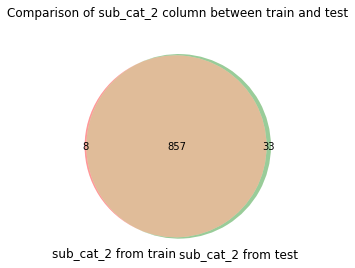

In [ ]:
from matplotlib_venn import venn2, venn2_circles
train_set = set(train['sub_cat_2'].tolist())
test_set = set(test['sub_cat_2'].tolist())
venn2([train_set, test_set], set_labels = ('sub_cat_2 from train', 'sub_cat_2 from test'))
plt.title('Comparison of sub_cat_2 column between train and test\n')

**Observation:**
Quan sát từ sơ đồ venn bên trên ta thấy được rằng có 857 mặt hàng level 2 đều có mặt ở tập train và tập test. Có 8 mặt hàng loại 2 chỉ có trong tập train trong khi đó là 33 loại chỉ có trong tập test 

In [ ]:
common_sub_cat_2 = train_set.intersection(test_set)

In [ ]:
len(common_sub_cat_2)

857

In [ ]:
sub_cat_2_only_in_test = test_set.difference(train_set)
print(sub_cat_2_only_in_test)

{'Changing Tables', 'Kitchen & Dining Room Furniture', 'Rugby', 'Pincushion', 'Zine', 'Puppet', 'Pretend', 'Portraits', 'Home', 'Traditional', 'Bench', 'Desk', 'Bedroom', 'Puppets', 'Geometric', 'Wall', 'Marbles', 'Messenger', 'Professional & Trade', 'Rugs', 'Jars', 'Table Runner', 'Rails & Rail Guards', 'Plushie', 'Teapots', 'Tandem', 'Computer', 'Squeegees', 'Fiber Art', 'Holidays', 'Amigurumi', 'Album', 'Windchimes'}


In [ ]:
sub_cat_2_only_in_train = train_set.difference(test_set)
print(sub_cat_2_only_in_train)

{'Tiles', 'Pad', 'Fashion Dolls Apparel', 'Child Friendly', 'Holiday Décor Storage', 'Artist Bears', 'RV Parts & Accessories', 'International Publications'}


In [ ]:
def plot_categories(category,title):
  '''
  This function takes in a category and title as input and 
  plots the bar chart for the same.
  '''
  sns.set(style="darkgrid")
  sns.barplot(x=category[:10].values, y=category[:10].index)
  plt.title(title)
  plt.xlabel('Counts', fontsize=12)
  plt.show()

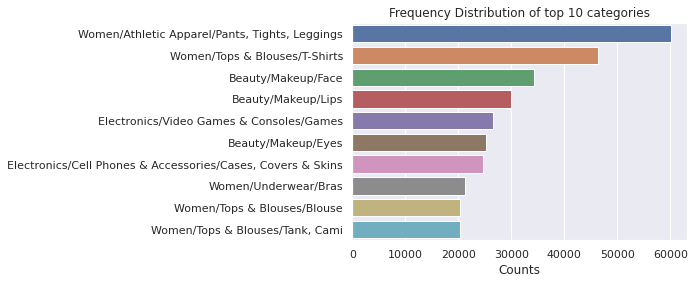

In [ ]:
plot_categories(category_count,"Frequency Distribution of top 10 categories")

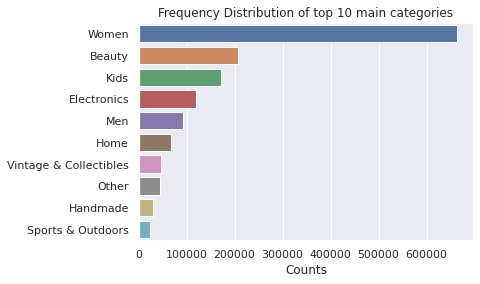

In [ ]:
plot_categories(main_category_count,"Frequency Distribution of top 10 main categories")

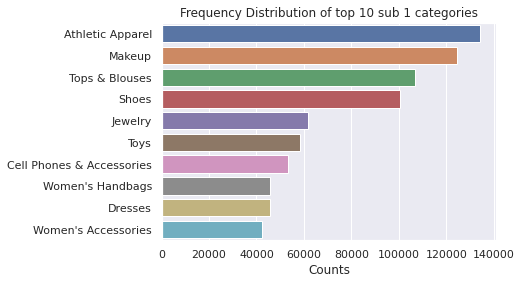

In [ ]:
plot_categories(sub_1_count,"Frequency Distribution of top 10 sub 1 categories")

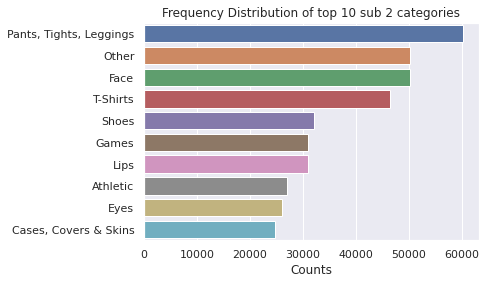

In [ ]:
plot_categories(sub_2_count,"Frequency Distribution of top 10 sub 2 categories")

### **2.2 Univariate Analysis of brand_name:**

In [ ]:
brand_count = train['brand_name'].value_counts()

In [ ]:
brand_count[:10]

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Name: brand_name, dtype: int64

In [ ]:
brand_count.count()

4809

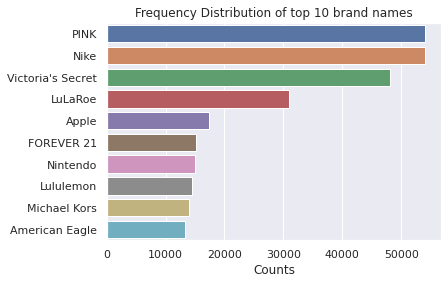

In [ ]:
sns.barplot(x=brand_count[:10].values, y=brand_count[:10].index)
plt.title('Frequency Distribution of top 10 brand names')
plt.xlabel('Counts', fontsize=12)
plt.show()

**Observation:**
Có tổng cộng 4809 thượng hiệu khác nhau. Hình bên trên thể hiện top 10 thương hiệu phổ biến nhất

### **2.3 Univariate analysis of the target variable 'Price':**

In [ ]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

**Observation:**
Mặt hàng có giá trị cao nhất là 2009 mặt hàng có giá trị nhỏ nhất là 0. Có tổng số 75% giá của các mặt hàng ở mức dưới 29, 50% giá của các mặt hàng dưới mức 17, và 25% giá các mặt hàng dưới 10 .(đơn vị $)

(array([1.393346e+06, 6.416700e+04, 1.477600e+04, 5.016000e+03,
        2.157000e+03, 1.162000e+03, 6.180000e+02, 3.400000e+02,
        2.110000e+02, 1.620000e+02, 1.360000e+02, 1.010000e+02,
        7.800000e+01, 6.100000e+01, 3.900000e+01, 3.500000e+01,
        2.000000e+01, 1.000000e+01, 2.100000e+01, 1.100000e+01,
        1.500000e+01, 3.000000e+00, 1.300000e+01, 5.000000e+00,
        3.000000e+00, 3.000000e+00, 1.000000e+01, 4.000000e+00,
        2.000000e+00, 1.000000e+01]),
 array([   0.        ,   66.96666667,  133.93333333,  200.9       ,
         267.86666667,  334.83333333,  401.8       ,  468.76666667,
         535.73333333,  602.7       ,  669.66666667,  736.63333333,
         803.6       ,  870.56666667,  937.53333333, 1004.5       ,
        1071.46666667, 1138.43333333, 1205.4       , 1272.36666667,
        1339.33333333, 1406.3       , 1473.26666667, 1540.23333333,
        1607.2       , 1674.16666667, 1741.13333333, 1808.1       ,
        1875.06666667, 1942.03333333, 

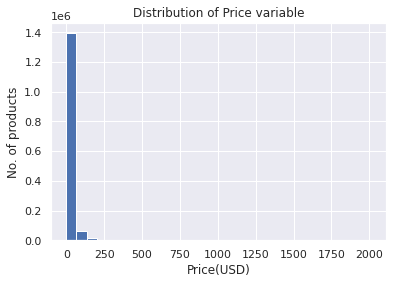

In [ ]:
plt.title("Distribution of Price variable")
plt.xlabel("Price(USD)")
plt.ylabel("No. of products")
plt.hist(train['price'],bins=30)

**Observation**
Giá của mặt hàng tuân theo phân phối lệch phải. Biến mục tiêu phân bố theo phân phối chuẩn sẽ thuận tiện hơn cho việc xử lý model, vì thế ta biến đổi đặc trưng giá về log của nó

In [ ]:
def log_price(price):
    return np.log1p(price)

In [ ]:
train['log_price'] = log_price(train['price'])

(array([8.74000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.87030e+04, 1.61390e+04, 6.38110e+04, 1.13886e+05, 2.02913e+05,
        2.50574e+05, 1.66759e+05, 2.33856e+05, 1.05214e+05, 1.07797e+05,
        8.20460e+04, 4.22870e+04, 2.93820e+04, 1.86720e+04, 1.22260e+04,
        7.43900e+03, 4.54800e+03, 2.42500e+03, 1.44000e+03, 6.95000e+02,
        3.95000e+02, 2.50000e+02, 1.12000e+02, 5.60000e+01, 3.60000e+01]),
 array([0.        , 0.25352967, 0.50705933, 0.760589  , 1.01411867,
        1.26764833, 1.521178  , 1.77470767, 2.02823733, 2.281767  ,
        2.53529667, 2.78882633, 3.042356  , 3.29588567, 3.54941533,
        3.802945  , 4.05647467, 4.31000433, 4.563534  , 4.81706367,
        5.07059333, 5.324123  , 5.57765267, 5.83118233, 6.084712  ,
        6.33824167, 6.59177133, 6.845301  , 7.09883067, 7.35236033,
        7.60589   ]),
 <a list of 30 Patch objects>)

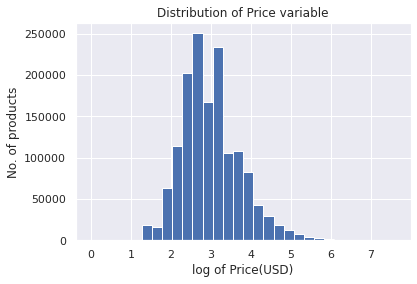

In [ ]:
sns.set(style="darkgrid")
plt.title("Distribution of Price variable")
plt.xlabel("log of Price(USD)")
plt.ylabel("No. of products")
plt.hist(train['log_price'],bins=30)

**Observation:**
Sau khi áp dụng chuyển đổi log of price thì giá của sản phẩm đã gần như tuân theo phân phối chuẩn. Ở đây sử dụng log(1+x) bởi vì có khá nhiểu sản phầm có giá là o mà log(0) là không xác định

### **2.4 Univariate analysis of item_description:**

In [ ]:
train['description_wc'] = [len(str(i).split()) for i in train['item_description']]

In [ ]:
train['description_wc'].describe()

count    1.482535e+06
mean     2.568858e+01
std      3.039363e+01
min      1.000000e+00
25%      7.000000e+00
50%      1.500000e+01
75%      3.100000e+01
max      2.450000e+02
Name: description_wc, dtype: float64

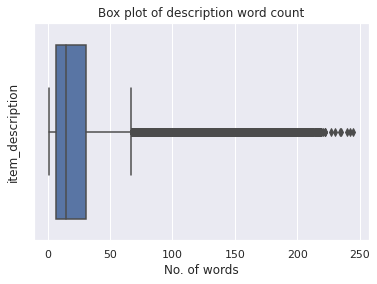

In [ ]:
sns.boxplot(train['description_wc'],orient='v')
plt.title("Box plot of description word count")
plt.xlabel("No. of words")
plt.ylabel("item_description")
plt.show()

**Observation:**
Quan sát đồ thị trên thì ta thấy hầu hết phần mô tả sản phẩm đều có ít hơn 40 từ

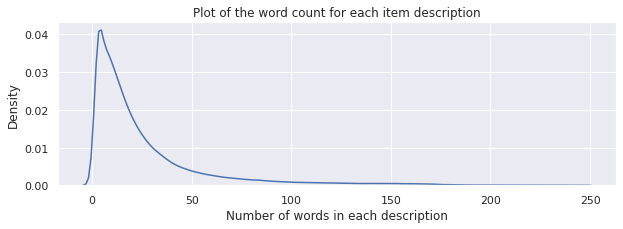

In [ ]:
plt.figure(figsize=(10,3))
sns.distplot(train['description_wc'], hist=False)
plt.title('Plot of the word count for each item description')
plt.xlabel('Number of words in each description')
plt.show()

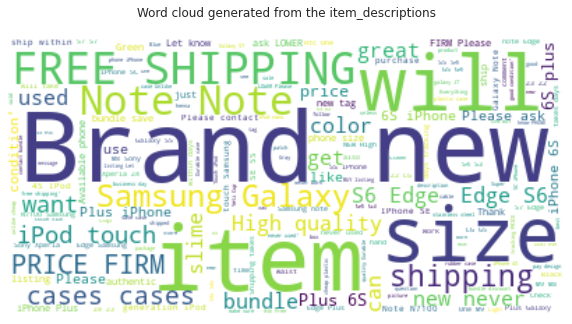

In [ ]:
word_counter = Counter(train['item_description'])
most_common_words = word_counter.most_common(500)

stopwords = get_stop_words('en')
stopwords.extend(['rm'])
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(str(most_common_words))

plt.figure(figsize=(10,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word cloud generated from the item_descriptions\n")
plt.axis("off")
plt.show()

**Observation:**
Những từ thường xuyên xuất hiện đó là brand , new, free, shipping, item,...

### **2.5 Univariate analysis of item_condition_id:**

In [ ]:
y = train['item_condition_id'].value_counts()

In [ ]:
y

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

Text(0, 0.5, 'No. of items (in 1000s)')

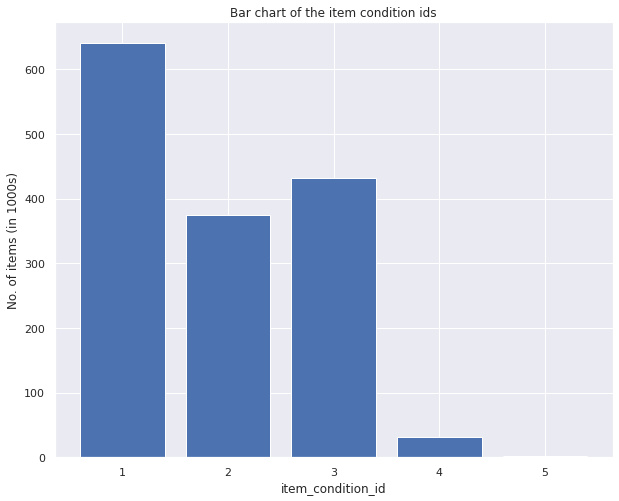

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(x = [1,3,2,4,5],height=y/1000,align='center') # A bar chart
plt.title("Bar chart of the item condition ids")
plt.xlabel('item_condition_id')
plt.ylabel('No. of items (in 1000s)')

**Observation:**
item_condition_id có phạm vi từ 1 đến 5. Phạm vi này thể hiện thứ tự phân loại mặt hàng, mặt hàng có điều kiện 1 là 'tốt nhất' và mặt hàng có điều kiện 5 là 'xấu nhất'. Có thể quan sát thấy rằng hầu hết các mặt hàng được rao bán đều trong tình trạng tốt, thể hiện rõ ràng từ biểu đồ trên. Theo đó, các mặt hàng điều kiện 1 cao hơn theo sau là điều kiện 3 và 2 trong khi các mặt hàng có điều kiện 4 và 5 là ít nhất.

### **2.6 Univariate analysis of shipping:**

Shipping 0 = 55.27 %
Shipping 1 = 44.73 %


Text(0, 0.5, 'Number of products')

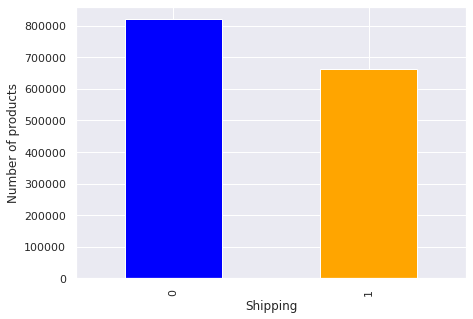

In [ ]:
total_rows = train.shape[0]
shipping_counts = train['shipping'].value_counts()
print("Shipping 0 =", round(shipping_counts[0]/total_rows*100,2),'%')
print("Shipping 1 =", round(shipping_counts[1]/total_rows*100,2),'%')
ax = train['shipping'].value_counts().plot.bar(color=['blue','orange'], figsize=(7,5))
ax.set_xlabel("Shipping")
ax.set_ylabel("Number of products")

**Observation**: không có sự thay chênh lệch nhiều giữa việc phí ship do người bán hay người mua chịu. Tuy nhiên nhìn vào bản đồ ta thấy người sẽ trả nhiều nhiều hơn người bán trả

### **2.7 Univariate analysis of item name:**

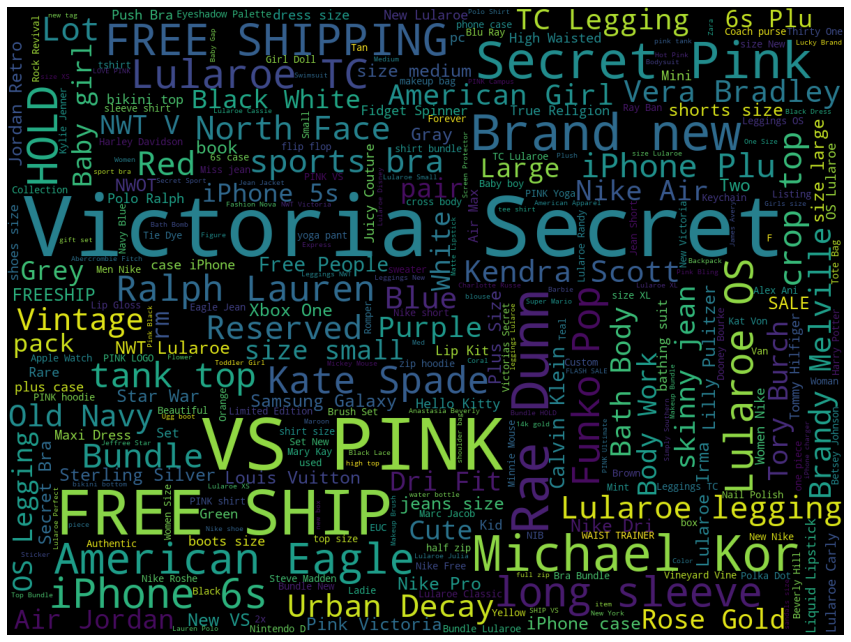

In [ ]:
wc = WordCloud(max_words=300,width = 1200, height = 900).generate(" ".join(train['name'].astype(str)))
plt.figure(figsize = (15, 14))
plt.imshow(wc)
plt.axis("off")
plt.show()

**Observation:** Có thể thấy rằng hầu hết các OP (poster gốc) đều đề cập đến tên thương hiệu và tên sản phẩm trong phần tên mặt hàng. Chúng ta có thể thấy rằng họ cũng đang làm nổi bật thông tin giao hàng miễn phí trong phần này, để thu hút người mua. Như đã thấy trước đó, có rất nhiều giá trị bị thiếu trong cột tên thương hiệu. Vì vậy, chúng ta có thể thử một số kỹ thuật tính năng hack để đoán tên thương hiệu bị thiếu từ tên mặt hàng.

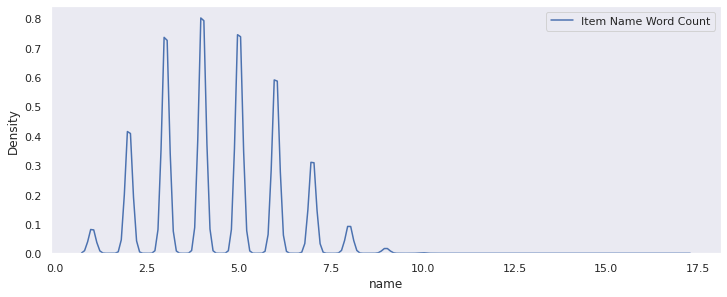

In [ ]:
word_counts = train['name'].str.split().str.len()
plt.figure(figsize=(12,10))
plt.subplot(211)
ax = sns.distplot(word_counts, hist=False, label="Item Name Word Count")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()
plt.show()

**Observation:** hầu hết phần tên sản phẩm thường có độ dài từ 2 đến 7 từ

### **2.8 Bivariate analysis:**


**2.8.1 Price Vs Shipping:**

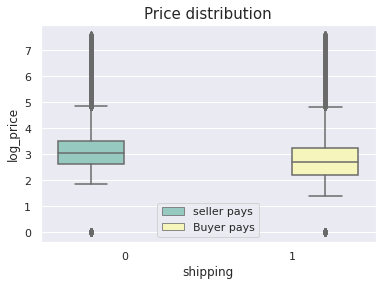

In [ ]:
ax = sns.boxplot(x=train['shipping'],y=train['log_price'],palette="Set3",hue=train['shipping'])
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["seller pays", "Buyer pays"])
plt.title('Price distribution', fontsize=15)
plt.show()

**Observation:**
Các sản phẩm có giá thành cao thì thường người bán sẽ trả luôn phí ship

**2.8.2 Price Vs Description length:**

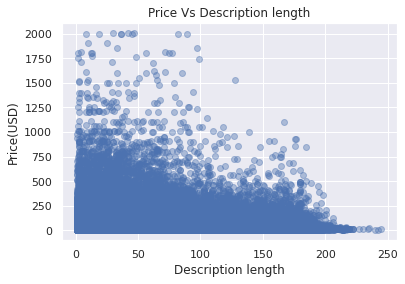

In [ ]:
plt.scatter(train['description_wc'],train['price'],alpha=0.4)
plt.title("Price Vs Description length")
plt.xlabel("Description length")
plt.ylabel("Price(USD)")
plt.show()

**Observation:**
Các sản phẩm có độ dài mô tả lớn hơn thì thường có giá thành bé hơn so với sản phẩm có độ dài mô tả ít hơn

**2.8.3 Price Vs branch name:**

**Top 15 expensive brands Wordcloud**

In [ ]:
top_brands = train.groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()[:15]

Text(0.5, 1.0, 'Top 15 expensive brands')

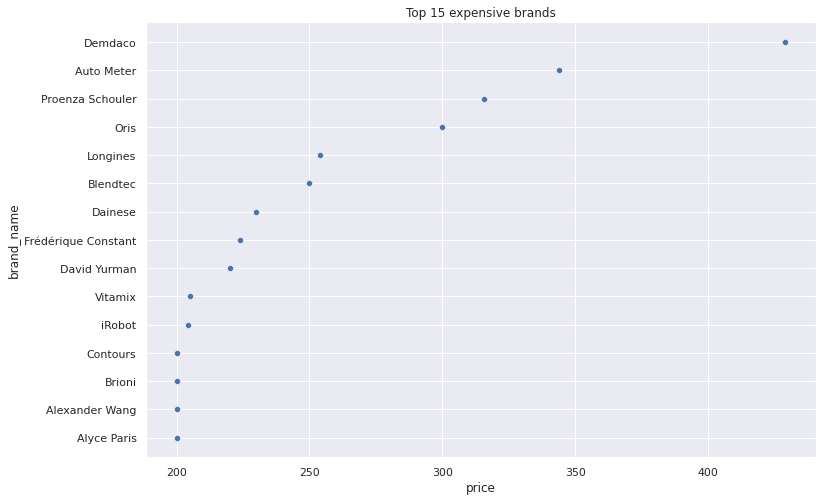

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=top_brands, x="price", y="brand_name")
plt.title("Top 15 expensive brands")

**Cheap and expensive brands**

In [ ]:
##print 90 to 100 percentile values with step size of 1. 
unique_gen_cat = train['main_category'].unique()
cat_threshold_percetile = {}
for gc_ in unique_gen_cat: 
    print(gc_,"\n-------------")
    for i in range(90,101):
        print(i,"th percentile is",np.percentile(train[train['main_category']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, i))
    cat_threshold_percetile[gc_]=np.percentile(train[train['main_category']==gc_].groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()['price'].values, 95)
    print()

Men 
-------------
90 th percentile is 50.0
91 th percentile is 52.63499999999999
92 th percentile is 55.120000000000005
93 th percentile is 59.0
94 th percentile is 65.17999999999984
95 th percentile is 72.0
96 th percentile is 81.0
97 th percentile is 96.54499999999996
98 th percentile is 131.08999999999992
99 th percentile is 180.0
100 th percentile is 300.0

Electronics 
-------------
90 th percentile is 67.0
91 th percentile is 69.5
92 th percentile is 72.0
93 th percentile is 74.0
94 th percentile is 80.0
95 th percentile is 85.0
96 th percentile is 100.0
97 th percentile is 130.0
98 th percentile is 137.0
99 th percentile is 150.0
100 th percentile is 250.0

Women 
-------------
90 th percentile is 45.0
91 th percentile is 47.27999999999997
92 th percentile is 49.36000000000013
93 th percentile is 52.440000000000055
94 th percentile is 57.51999999999998
95 th percentile is 65.0
96 th percentile is 73.68000000000006
97 th percentile is 86.0
98 th percentile is 101.17999999999984


**2.8.4 category and price**

In [ ]:
main_cat_median = train.groupby('main_category').median().sort_values("price", ascending=False)['price'].reset_index()

Text(0.5, 1.0, 'Median prices for each main category')

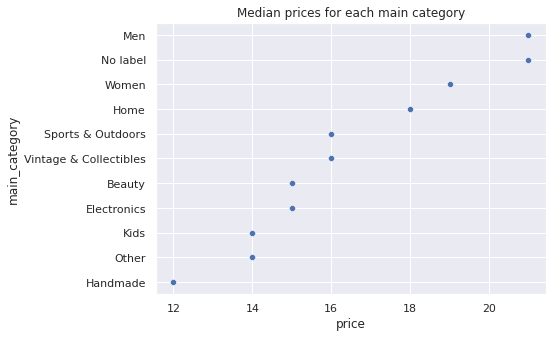

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=main_cat_median, x="price", y="main_category")
plt.title("Median prices for each main category")

In [ ]:
sub_cat_1_cat_median = train.groupby('sub_cat_1').median().sort_values("price", ascending=False)['price'].reset_index()

Text(0.5, 1.0, 'Median prices for each subcat 1 category')

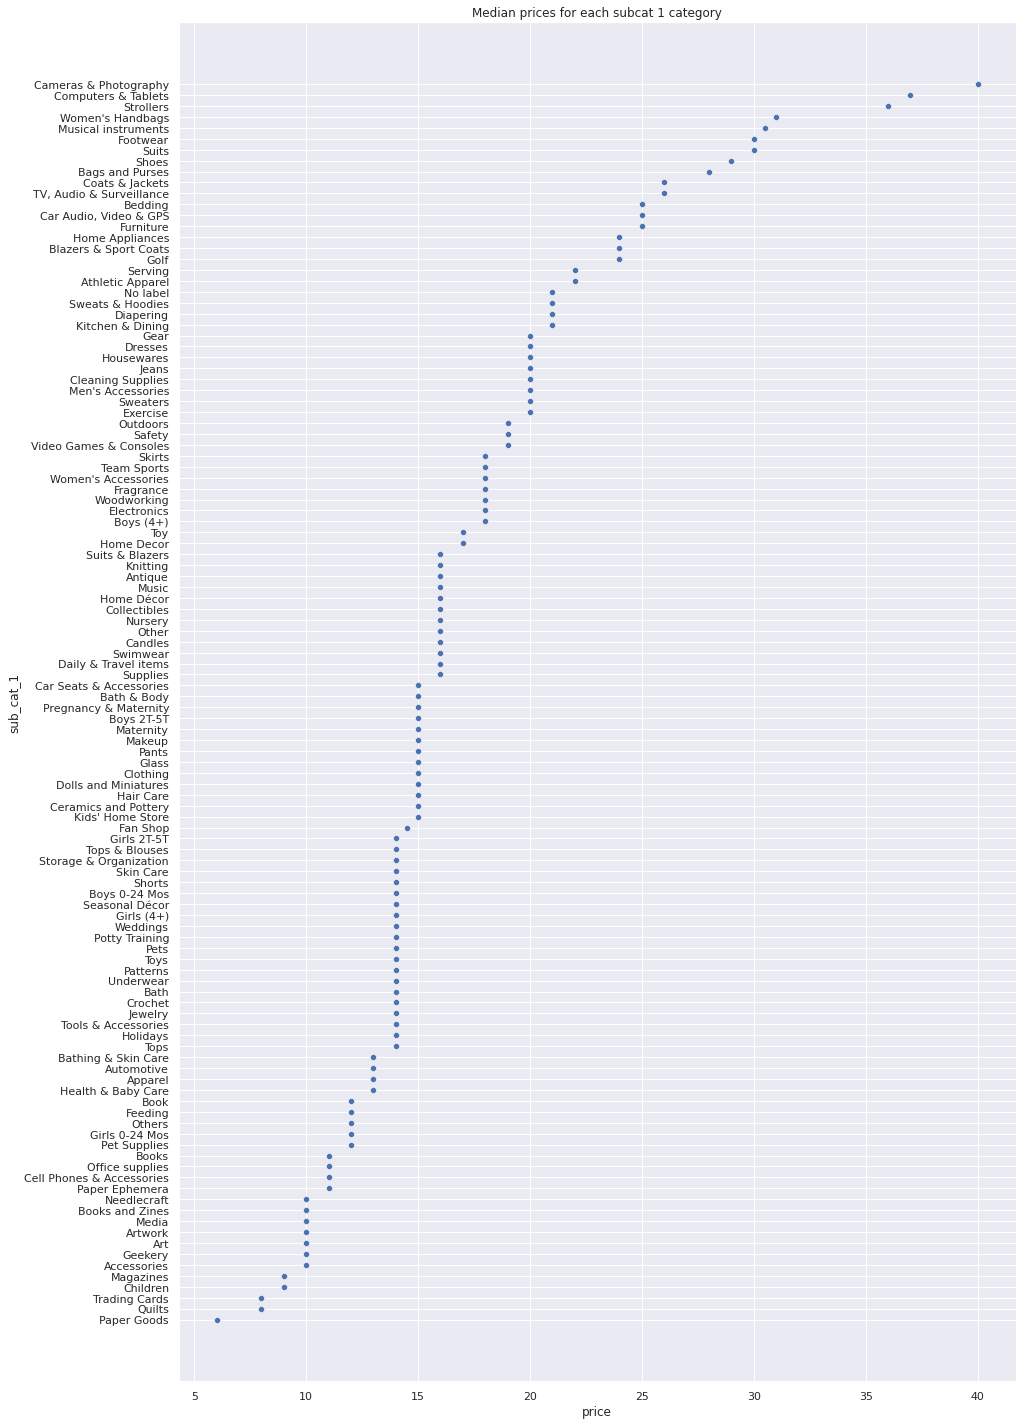

In [ ]:
plt.figure(figsize=(15,25))
sns.scatterplot(data=sub_cat_1_cat_median, x="price", y="sub_cat_1")
plt.title("Median prices for each subcat 1 category")

### **2.9 Trivaiate analysis:**

**Brand & Condition -> Price**

In [ ]:
def get_interactions(col1, col2, top_brand=None):
    interaction_df = pd.DataFrame()
    if top_brand is not None:
        unique_values_col1 = top_brand['brand_name'].unique()
    else:
        unique_values_col1 = train[col1].unique()
        
    for uv in unique_values_col1:
        interaction_df = pd.concat([interaction_df, train[train[col1]==uv].groupby(col2).median()['price'].rename(uv)], axis=1)
    return interaction_df

def visualize_interactions(interaction_df, title, annot_=True):
    plt.figure(figsize=(12,7))
    ax = sns.heatmap(
        interaction_df,
        cmap="Blues",
        annot=annot_,
        cbar_kws={'label': 'Prices', 'orientation': 'vertical'},
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.title(title)

In [ ]:
top_brands = train.groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()[:15]

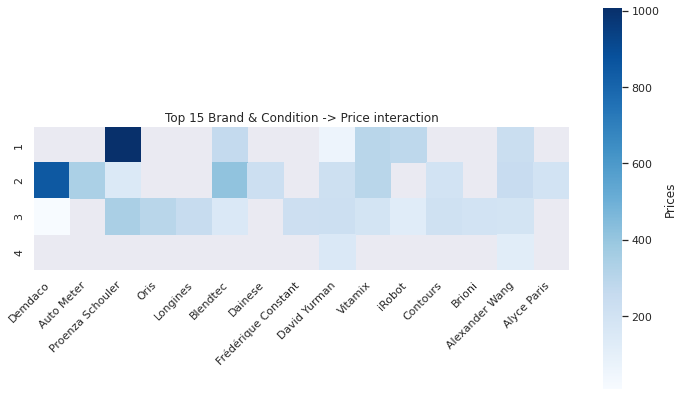

In [ ]:
interaction_df = get_interactions('brand_name', 'item_condition_id', top_brand=top_brands)
visualize_interactions(interaction_df, 'Top 15 Brand & Condition -> Price interaction', annot_=False)

**Brand & Category -> Price**

In [ ]:
top_brands = train.groupby('brand_name').median().sort_values("price", ascending=False)['price'].reset_index()[:15]

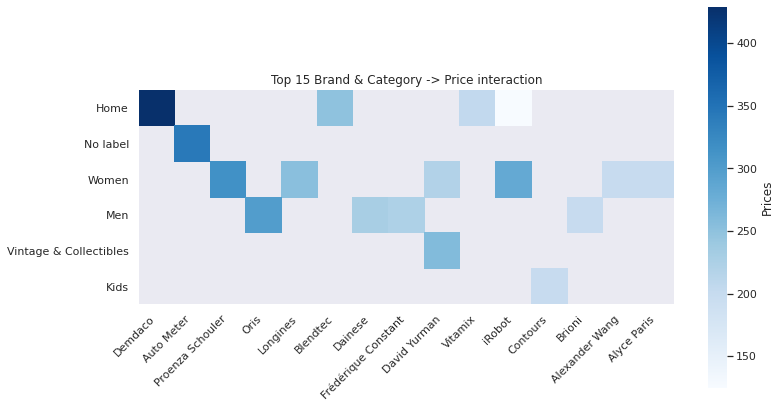

In [ ]:
interaction_df = get_interactions('brand_name', 'main_category', top_brand=top_brands)
visualize_interactions(interaction_df, 'Top 15 Brand & Category -> Price interaction', annot_=False)

**Categroy & Condition -> Price**

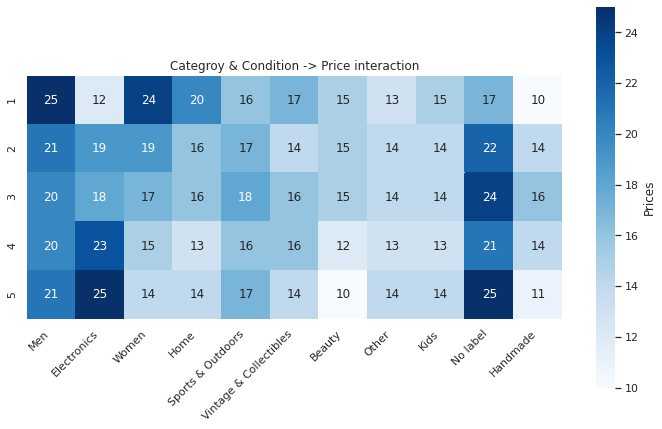

In [ ]:
interaction_df = get_interactions('main_category', 'item_condition_id')
visualize_interactions(interaction_df, 'Categroy & Condition -> Price interaction')